# Reward normalization comparison

#### Imports


In [1]:
from math import isnan
from abc import ABC, abstractmethod

import torch
from torch import nn, optim
import numpy as np
from kilroyplot.plot import plt
from torch.distributions.categorical import Categorical
import einops as ein

#### Configuration


In [2]:
n_actions = 100
n_times = 10
iterations = 1000
milestone = 1000
sample_size = 10
lr = 0.01
target_mean = 10000
target_std = 1000
window_size = 100

#### Seeding

In [3]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

#### Policy


In [4]:
class Policy(nn.Module):
    def __init__(self, n_actions, n_hidden=3):
        super().__init__()
        first = [nn.Linear(1, n_actions), nn.LeakyReLU()]
        hidden = []
        for _ in range(n_hidden):
            hidden.append(nn.Linear(n_actions, n_actions))
            hidden.append(nn.LeakyReLU())
        last = [nn.Linear(n_actions, n_actions), nn.LogSoftmax(dim=1)]
        self._layers = nn.Sequential(*first, *hidden, *last)

    def forward(self, x):
        return self._layers(x)

#### Reward functions


In [5]:
class RewardFunction(ABC):
    @abstractmethod
    def __call__(self, x, iteration):
        pass

In [6]:
class BaseRewardFunction(RewardFunction):
    def __init__(self, action_rewards):
        self._action_rewards = action_rewards

    def __call__(self, x, iteration):
        return self._action_rewards[x]

In [7]:
class ScaledRewardFunction(RewardFunction):
    def __init__(self, base, target_mean, target_std, milestone):
        self._base = base
        self._target_mean = target_mean
        self._target_std = target_std
        self._milestone = milestone

    def __call__(self, x, iteration):
        mean = self._target_mean * min(1, iteration / self._milestone)
        std = (self._target_std - 1) * min(1, iteration / self._milestone) + 1
        return self._base(x, iteration) * std + mean

In [8]:
class NormalizedScaledRewardFunction(RewardFunction):
    def __init__(self, scaled, window_size):
        self._scaled = scaled
        self._window_size = window_size
        self._buffer = []

    def __call__(self, x, iteration):
        rewards = self._scaled(x, iteration)
        for reward in rewards.flatten():
            self._buffer.append(reward)
            if len(self._buffer) > self._window_size:
                self._buffer.pop(0)
        buffer = torch.tensor(self._buffer)
        mean = buffer.mean().item()
        std = buffer.std().item()
        if isnan(std) or std < 1e-6:
            return rewards - mean
        return (rewards - mean) / std

In [9]:
action_rewards = torch.randn(n_actions)
base_reward_function = BaseRewardFunction(action_rewards)
scaled_reward_function = ScaledRewardFunction(
    base_reward_function, target_mean, target_std, milestone
)
normalized_scaled_reward_function = NormalizedScaledRewardFunction(
    scaled_reward_function, window_size
)

In [10]:
def plot_action_rewards(rewards, x_label="Action", y_label="Reward"):
    plt.bar(range(n_actions), rewards)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

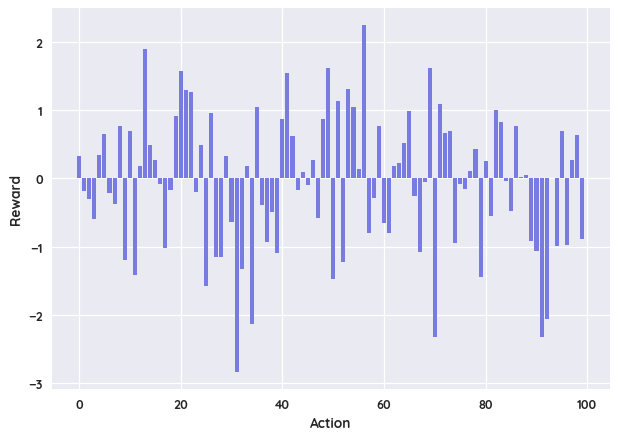

In [11]:
plot_action_rewards(action_rewards)

#### Training


In [12]:
def sample(logprobs, n):
    return Categorical(logprobs.exp()).sample((n,)).flatten()

In [13]:
def calculate_loss(logprobs, rewards):
    return -torch.mean(logprobs * rewards)

In [14]:
def gather_logprobs(logprobs, samples):
    return logprobs.flatten().gather(0, samples)

In [15]:
def train_iteration(
    policy, base_reward_function, target_reward_function, iteration
):
    logprobs = policy(torch.zeros(1, 1))
    samples = sample(logprobs, sample_size)
    base_rewards = base_reward_function(samples, iteration)
    target_rewards = target_reward_function(samples, iteration)
    logprobs = gather_logprobs(logprobs, samples)
    loss = calculate_loss(logprobs, target_rewards)
    return loss.mean(), base_rewards

In [16]:
def train(
    policy, optimizer, base_reward_function, target_reward_function, iterations
):
    all_rewards = []
    for i in range(iterations):
        optimizer.zero_grad()
        loss, rewards = train_iteration(
            policy, base_reward_function, target_reward_function, i
        )
        all_rewards.append(rewards)
        loss.backward()
        optimizer.step()
    return torch.stack(all_rewards)

#### Experiments


In [17]:
def run(
    n_actions,
    n_times,
    lr,
    iterations,
    base_reward_function,
    target_reward_function,
):
    all_rewards = []
    for _ in range(n_times):
        policy = Policy(n_actions)
        optimizer = optim.SGD(policy.parameters(), lr=lr)
        rewards = train(
            policy,
            optimizer,
            base_reward_function,
            target_reward_function,
            iterations,
        )
        all_rewards.append(rewards)
    return torch.stack(all_rewards)

In [18]:
def plot_rewards(
    rewards, label, x_label="Iteration", y_label="Reward", alpha=0.5
):
    rewards = ein.rearrange(rewards, "n t s -> t n s").mean(dim=-1)
    median = rewards.median(dim=1).values
    lower, upper = np.percentile(rewards, [25, 75], axis=1)
    plt.plot(median, label=label)
    plt.fill_between(range(len(median)), lower, upper, alpha=alpha)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

In [19]:
rewards_base = run(
    n_actions,
    n_times,
    lr,
    iterations,
    base_reward_function,
    base_reward_function,
)

In [20]:
rewards_unnormalized = run(
    n_actions,
    n_times,
    lr,
    iterations,
    base_reward_function,
    scaled_reward_function,
)

In [21]:
rewards_normalized = run(
    n_actions,
    n_times,
    lr,
    iterations,
    base_reward_function,
    normalized_scaled_reward_function,
)

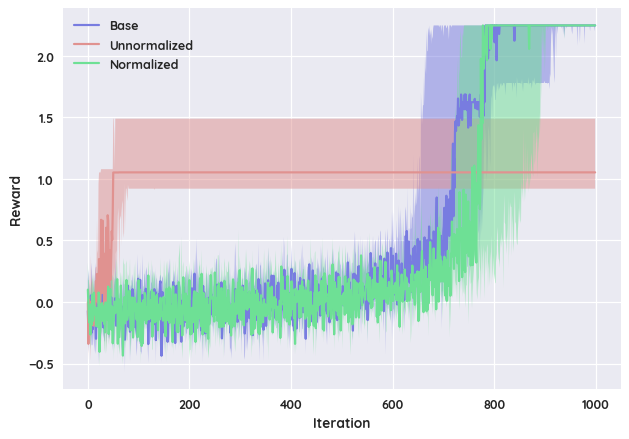

In [22]:
plot_rewards(rewards_base, "Base")
plot_rewards(rewards_unnormalized, "Unnormalized")
plot_rewards(rewards_normalized, "Normalized")